In [1]:
# Parth Parakh & Hamza BC
# purpose: based on code by Yiran Cui, Sebastian Rollin, Guido Germano, Stability of calibration procedures: fractals in the Black-Scholes model,arXiv:1612.0195, 2016.

## import modules
import numpy as np
import sys
from numpy import linalg as LA
from scipy import special as sp
import matplotlib.pyplot as plt

In [2]:
## Helper function
def isInRange(x):
    #returns true if x is within the reasonable region for normcdfc
    #by reasonable region, we mean the figure in http://mathworld.wolfram.com/Erf.html
    phi = np.angle(x);
    r = np.abs(x);
    if( np.log(r)>300 or np.log(r)>3.5 and ((phi>np.pi/4 and phi<3*np.pi/4) or (phi<-np.pi/4 and phi>-3*np.pi/4)) ) :
        return 0;
    return 1;

def normcdfc(x):
    IsInRange = isInRange(x);
    if(not IsInRange):
        y = 0;
    else:
        y = 0.5+0.5*sp.erf(x/(np.sqrt(2)));
    if np.isnan(y):
        print('NaN returned by normcdfc, this should not happen, please fix it');
        sys.exit(1)
    if np.isinf(np.real(y)):
        print('Inf returned by normcdfc, this should not happen, please fix it');
        sys.exit(1)
    return y, IsInRange;


#-----------------------------------------------
# returns                                      #
# result =   1 converges to a complex root     #
#            0 converges to a real root        #
#           -1 diverges                        #
# iter = number of steps it takes to terminate #
# convergeVol: convergence value               #
#-----------------------------------------------

def BSiteration(v0, x, b, realvol, flag, maxit, tol):
    result=-2;iterr=0;convergeVol=0;
    while(iterr <= maxit):
        iterr=iterr+1;
        d1 = (x/v0 + 0.5*v0)*flag;
        d2 = (x/v0 - 0.5*v0)*flag;
        N1, isInRange1 = normcdfc(d1);
        N2, isInRange2 = normcdfc(d2);
        if( (not isInRange1) or (not isInRange2) ):
            convergeVol = 0;
            result = -1;       # divergence
            break
        numerator = flag*np.exp(0.5*x)*N1 - flag*np.exp(-0.5*x)*N2-b;
        #denominator = (1/np.sqrt(2*np.pi)) * np.exp((-x*x)/(2*(v0**2))-(v0**2)/8);
        denominator = 1/np.sqrt(2*np.pi)*np.exp(-x*x/(2*(v0**2))-(v0**2)/8);
        v1 = v0 - numerator/denominator;
        if (np.isinf(np.real(v1))):
            convergeVol = 0;
            result = -1; # divergence
            break
        if ( LA.norm(v1-v0)/LA.norm(v0) < tol) :
            convergeVol = v1;
            if(LA.norm(convergeVol - realvol)/LA.norm(realvol))<tol:
                result = 0;
            else :
                result = 1;
            break
        v0 = v1;
    return result, iterr, convergeVol;

C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in cdouble_scalars
C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in cdouble_scalars
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


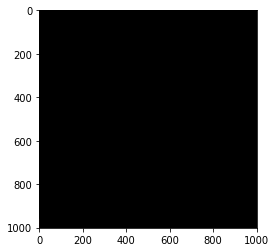

In [4]:
if __name__ == "__main__":
    # main caller
    S = 102.10;
    T = 1;
    r = 0.0268;
    q = 0.0271;
    F = S*np.exp((r-q)*T);
    realvol = 0.112;
    K = 102.76;
    flag = 1; # = 1 for call options; = -1 for put optins
    x = np.log(F/K);
    d1 = (x/(realvol*np.sqrt(T)) + realvol*np.sqrt(T)/2)*flag;
    d2 = (x/(realvol*np.sqrt(T)) - realvol*np.sqrt(T)/2)*flag;
    Nd1 = 0.5+0.5*sp.erf(d1/(np.sqrt(2)));
    Nd2 = 0.5+0.5*sp.erf(d2/(np.sqrt(2)));
    pv = np.exp(-r*T)*flag*(F*Nd1 - K*Nd2);
    b = np.exp(r*T)*pv/np.sqrt(F*K);
    
    N = 1001; #the figure plots N*N initial points
    result = np.zeros((N, N));
    iterr = np.zeros((N, N));
    convergeVol = np.zeros((N, N),dtype=complex);

    ubRe = 1000;
    lbRe = -1000;
    ubIm = 1000;
    lbIm = -1000;
    ReAxis = np.linspace(lbRe,ubRe,N);
    ImAxis = np.linspace(lbIm,ubIm,N);
    xx,yy = np.meshgrid(ReAxis,ImAxis);
    z = xx + 1j*yy;
    
    maxit = 99;
    tol = 1e-8;
    #The following Newton-Raphson iteration returns:
    #"result": records whether it converges
    #"iter": records the number of iterations
    #"convergeVol": records the convergence value
    for m in range(N):
        for n in range(N):
            v0 = 0.01 * z[m][n];
            result[m][n], iterr[m][n], convergeVol[m][n] = BSiteration(v0, x, b, realvol, flag, maxit, tol);
            break
            
    R = np.ones((N,N));
    G = np.zeros((N,N));
    B = np.ones((N,N));

    #Attraction basin
    for m in range(N):
        for n in range(N):
            if(result[m][n]==1):
                # Converged to a complex root: shade of red
                R[m][n] = 204/255 * (7*iterr[m][n])/maxit;
                G[m][n] =  56/255 * (7*iterr[m][n])/maxit;
                B[m][n] =  49/255 * (7*iterr[m][n])/maxit;
            elif result[m][n] == 0:
                #Converged to a real root: shade of blue
                R[m][n] =  50/255*10*(iterr[m][n]/maxit);
                G[m][n] =  91/255*10*(iterr[m][n]/maxit);
                B[m][n] = 153/255*10*(iterr[m][n]/maxit);
            elif result[m,n] < 0:
                #Did not converge: black
                R[m][n] =  10/255;
                G[m][n] =  10/255;
                B[m][n] =  10/255;
     
    RGB = np.zeros((N,N,3))
    RGB[:,:,0] = R;
    RGB[:,:,1] = G;
    RGB[:,:,2] = B;
    
    plt.imshow(RGB)


In [9]:
# Test cells

# params for the loops / funcs
S = 102.10;
T = 1;
r = 0.0268;
q = 0.0271;
F = S*np.exp((r-q)*T);
realvol = 0.112;
K = 102.76;
flag = 1; # = 1 for call options; = -1 for put optins
x = np.log(F/K);
N = 1001; #the figure plots N*N initial points
result = np.zeros((N, N));
convergeVol = np.zeros((N, N),dtype=complex);
ubRe = 1000;
lbRe = -1000;
ubIm = 1000;
lbIm = -1000;
ReAxis = np.linspace(lbRe,ubRe,N);
ImAxis = np.linspace(lbIm,ubIm,N);
xx,yy = np.meshgrid(ReAxis,ImAxis);
z = xx + 1j*yy;

d1 = (x/(realvol*np.sqrt(T)) + realvol*np.sqrt(T)/2)*flag;
d2 = (x/(realvol*np.sqrt(T)) - realvol*np.sqrt(T)/2)*flag;
Nd1 = 0.5+0.5*sp.erf(d1/(np.sqrt(2)));
Nd2 = 0.5+0.5*sp.erf(d2/(np.sqrt(2)));
pv = np.exp(-r*T)*flag*(F*Nd1 - K*Nd2);
b = np.exp(r*T)*pv/np.sqrt(F*K);
maxit = 99;
tol = 1e-8;

#..............................................................#
for m in range(N):
    for n in range(N):
        v0 = 0.01 * z[m][n];
        result[m][n], iterr[m][n], convergeVol[m][n] = BSiteration(v0, x, b, realvol, flag, maxit, tol);
        break

#BSiteration(v0, x, b, realvol, flag, maxit, tol)
result[m][n], iterr[m][n], convergeVol[m][n] = BSiteration(v0, x, b, realvol, flag, maxit, tol);
convergeVol[-1:]

C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: divide by zero encountered in cdouble_scalars
C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in cdouble_scalars
C:\Users\hamza\.julia\conda\3\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: overflow encountered in cdouble_scalars


array([[-8.0220146+8.99261197j,  0.       +0.j        ,
         0.       +0.j        , ...,  0.       +0.j        ,
         0.       +0.j        ,  0.       +0.j        ]])